# 0.0 IMPORTS

## 0.1 - LIBRARIES

In [115]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime as dt

from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from matplotlib            import rcParams
from IPython.display       import Image
from IPython.core.display  import HTML





## 0.2 - HELPER FUNCTIONS

In [168]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [117]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3 - LOADING DATA

In [118]:
# Load sales and store file using pandas library

df_sales_raw = pd.read_csv('Data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('Data/store.csv', low_memory=False)

# mergering booth df loaded before to join all information in an unique dataset

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [119]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
108841,687,6,2015-04-25,9579,802,1,0,0,0,d,c,2770.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTION

## 1.1 RENAME COLUMNS

In [120]:
df1 = df_raw.copy()

In [121]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [122]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 DATA DIMENSIONS

In [123]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 DATA TYPES

In [124]:
df1['date'] = pd.to_datetime(df1['date']) 
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 CHECK NA

In [125]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [126]:
#competition_distance: Se o dado está NA, provavelmente é pq não há competidor próximo. Por isso, podemos preencher com a máxima distância.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x) 

#competition_open_since_month: 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval 
month_map = {1: 'Jan',
             2: 'Feb',
             3: 'Mar',
             4: 'Apr',
             5: 'May',
             6: 'Jun',
             7: 'Jul',
             8: 'Aug',
             9: 'Sep',
             10: 'Oct',
             11: 'Nov',
             12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [127]:
print(df1['competition_distance'].isna().sum())
df1['competition_distance'].max()

0


200000.0

In [128]:
df1.sample(4).T

,568128,740494,937376,157260
store,264,920,447,46
day_of_week,5,5,3,4
date,2014-02-07 00:00:00,2013-09-06 00:00:00,2013-03-13 00:00:00,2015-03-12 00:00:00
sales,8138,4319,3785,4080
customers,1059,478,493,554
open,1,1,1,1
promo,1,0,0,0
state_holiday,0,0,0,0
school_holiday,1,1,0,0
store_type,a,a,a,c


## 1.6 Chance Types

In [129]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [130]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])

cat_attributes.sample()

,state_holiday,store_type,assortment,promo_interval,month_map
328936,0,c,c,"Feb,May,Aug,Nov",Sep


### 1.7.1 Numerical Atributes

In [131]:
#Central Tendency:
#avg
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
#median
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion
#std
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
#min
d2 = pd.DataFrame(num_attributes.apply(min)).T
#max
d3 = pd.DataFrame(num_attributes.apply(max)).T
#range
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
#skew
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
#kurtosis
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                                      
#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['atributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m




,atributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


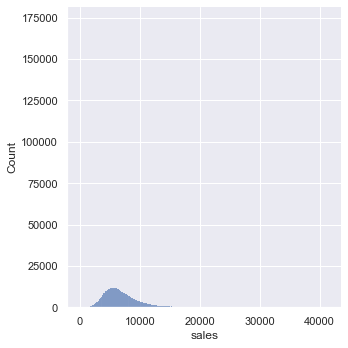

In [132]:
sns.displot(df1['sales'])


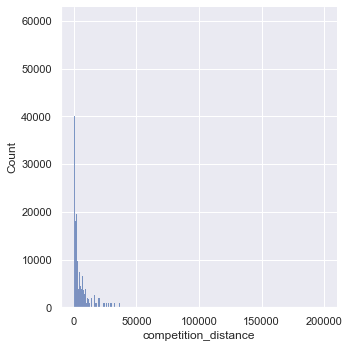

In [133]:
sns.displot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [134]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

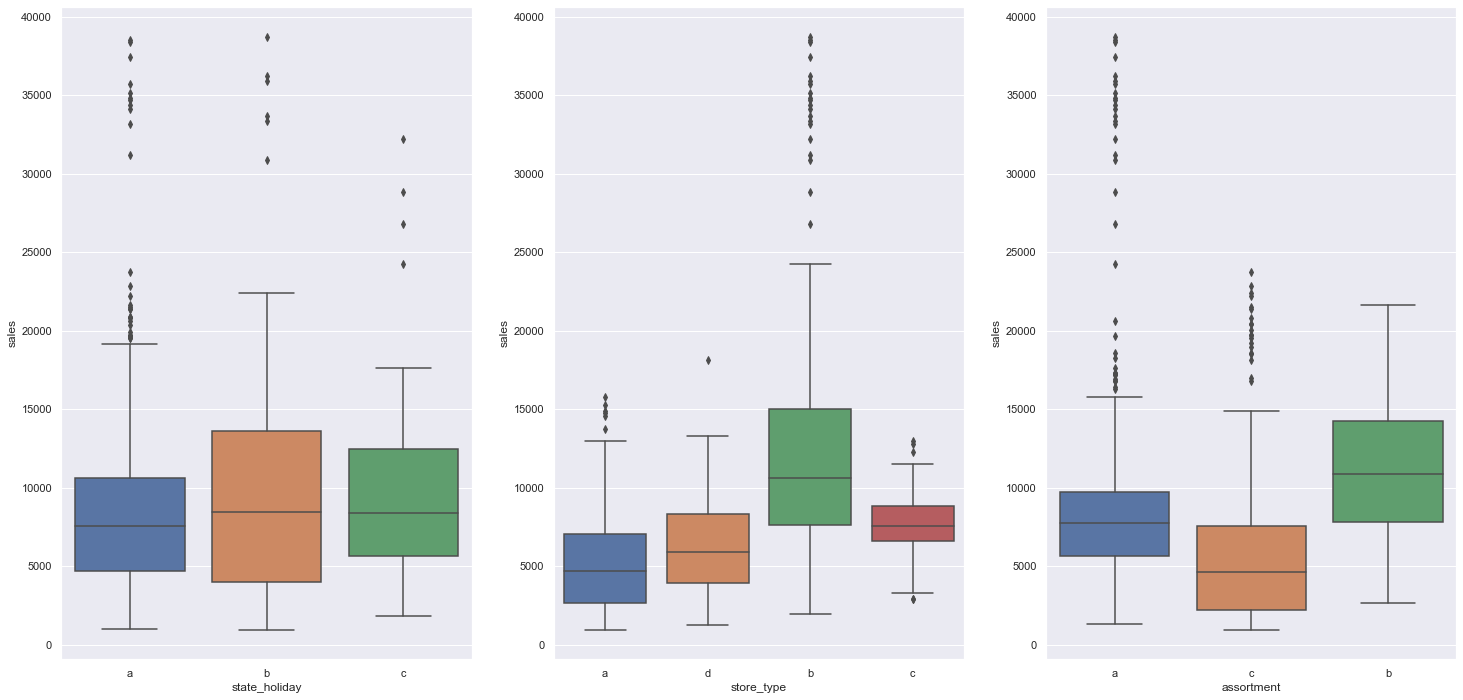

In [135]:
aux1 = df1[(df1['state_holiday']!= '0') & (df1['sales']> 0)] 

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

## 2.1 Creating a Midmap Hypothesis

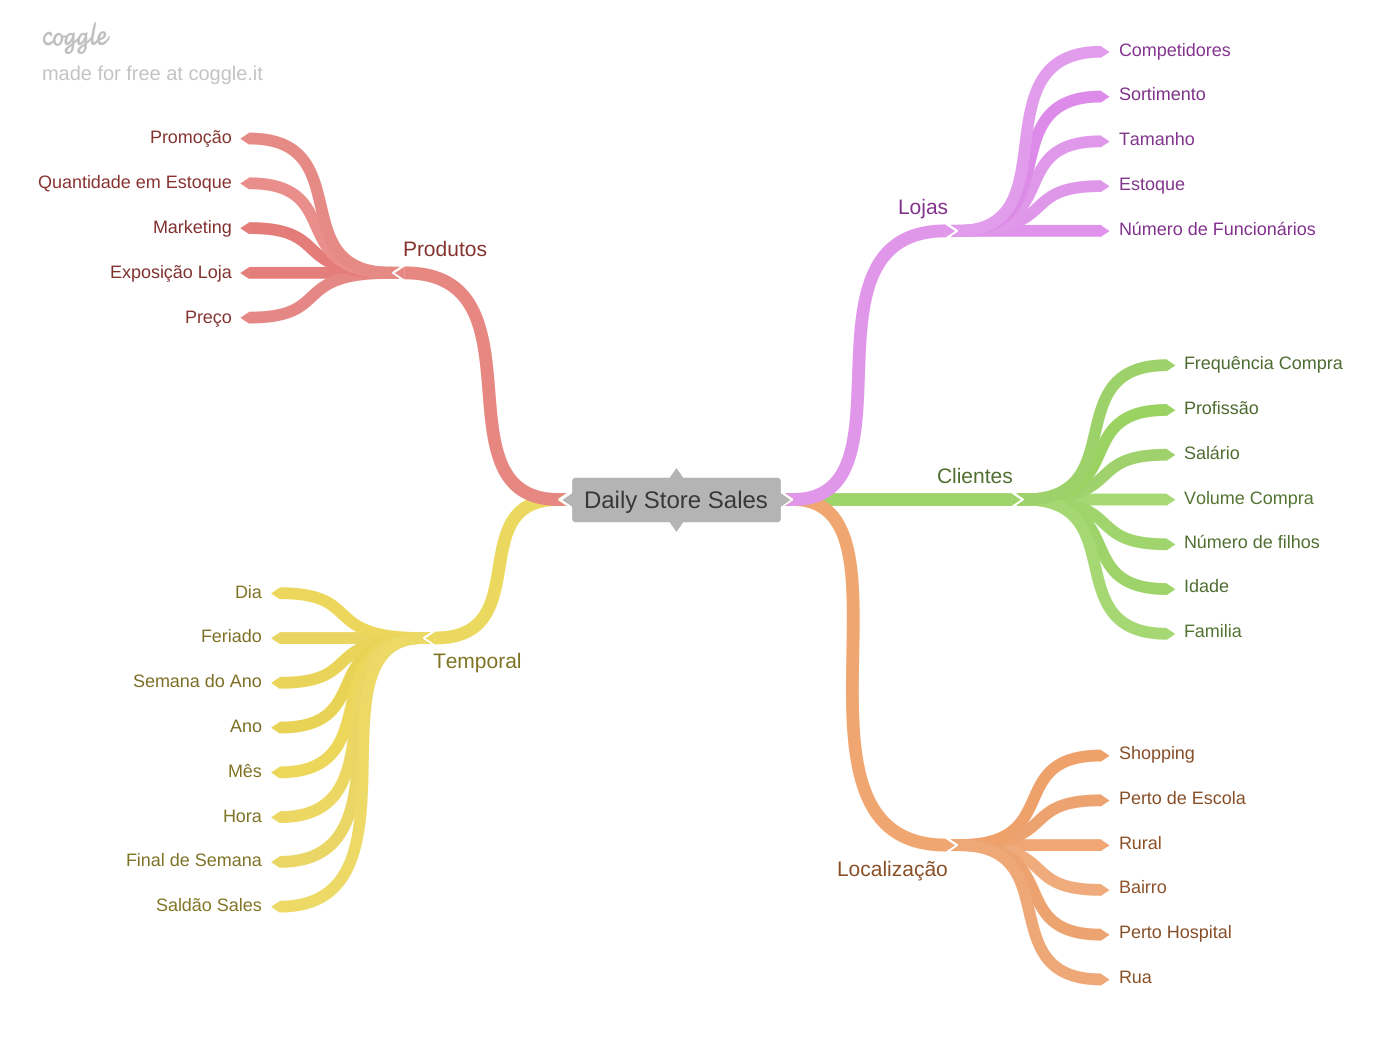

In [136]:
Image('Img/mindmap_sales.png')

## 2.2 Creating Hypothesis

### 2.2.1 Store Hypothesis

**H1.** Lojas com maior quadro de funcionários deveriam vender mais.

**H2.** Lojas com maior capacidade de estoque deveriam vender mais.

**H3.** Lojas com maior porte deveriam vender mais.

**H4.** Lojas com maior sortimento deveriam vender mais.

**H5.** Lojas com competidores mais próximos deveriam vender menos.

**H6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Product Hypothesis

**H1.** Lojas que investem mais em marketing deveriam vender mais.

**H2.** Lojas que expoe mais os produtos nas vitrines deveriam vender mais

**H3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**H4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais

**H5.** Lojas com promoções mais agressivas deveriam vender mais

**H6.** Lojas com mais dias de promoção deveriam vender mais.

**H7.** Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3 Time Hypothesis

**H1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**H2.** Lojas deveriam vender mais ao longo dos anos.

**H3.** Lojas deveriam vender mais no segundo semestre do ano.

**H4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**H5.** Lojas deveriam vender menos aos finais de semana.

**H6.** Lojas deveriam vender menos durante as férias/feriados escolares

## 2.3 Final Hypothesis List

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engineering

In [137]:
df2 = df1.copy()
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
#df2['competition_since'] = df2.apply(lambda x: dt.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
#df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( np.int64 )

df2['competition_since'] = df2.apply( lambda x: dt.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: dt.datetime.strptime( x + '-1', '%Y-%W-%w' ) - dt.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( np.int64 )

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c'else 'regular_day' )



C:\Users\pgd_r\AppData\Local\Temp/ipykernel_11692/1517331779.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [138]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Feature Filtering

In [139]:
df3 = df2.copy()

## 3.1 Row FIltering

In [140]:
#open!=0
#sales>0
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

## 3.2 Columns Filtering

In [141]:
#customers
cols_drop = ['customers','open','promo_interval','month_map']

df3 = df3.drop(cols_drop, axis=1)

In [142]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0 Exploration Data Analysis

In [143]:
df4 = df3.copy()
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### 4.1 Univariete Analysis

#### 4.1.1 Response Variable

C:\Users\pgd_r\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

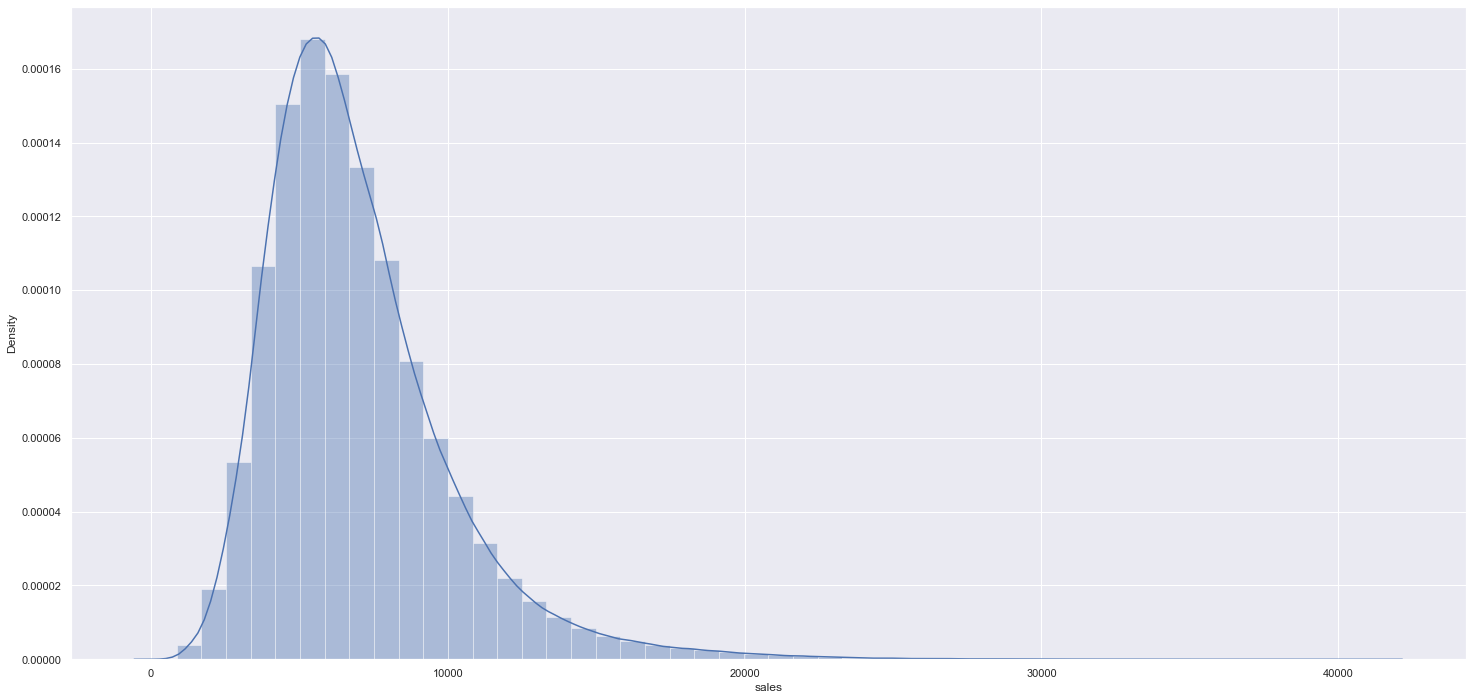

In [144]:
sns.distplot(df4['sales'])

#### 4.1.2 Numerical Variable 

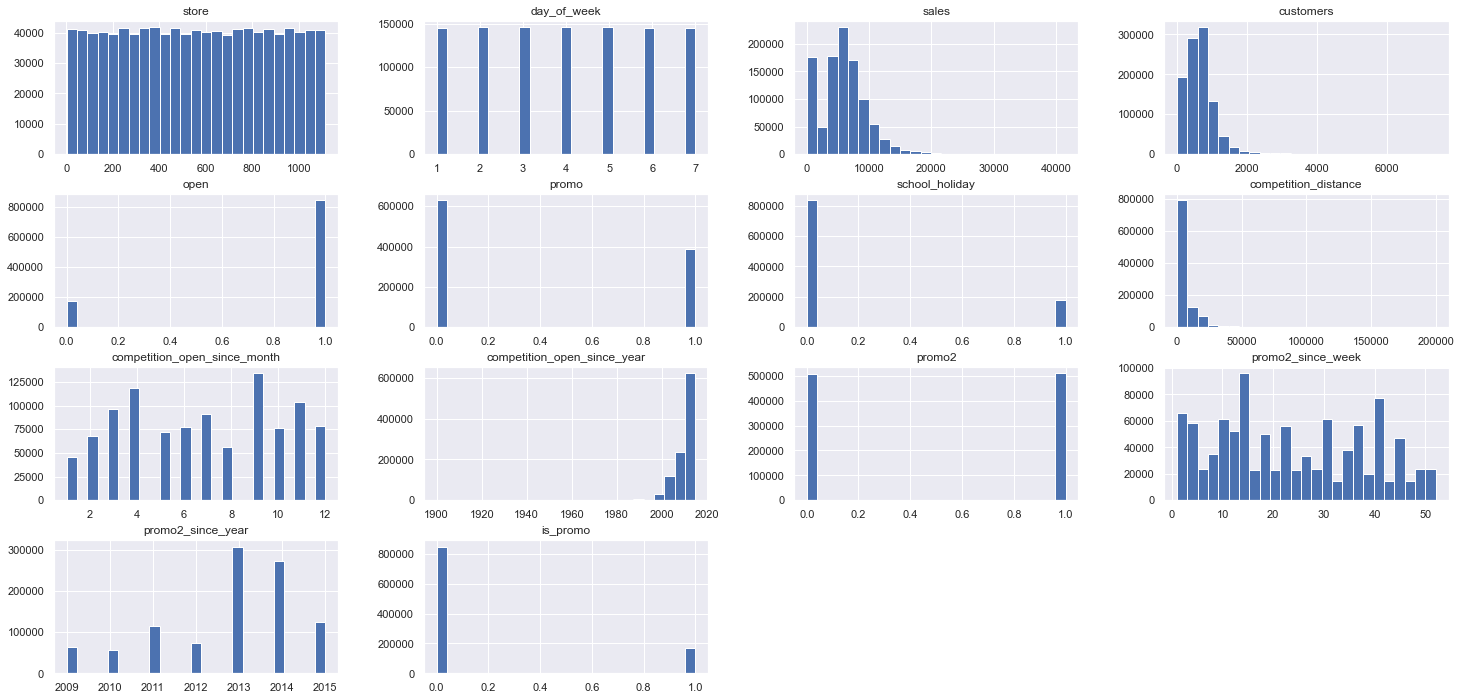

In [145]:
num_attributes.hist(bins=25);

### 4.2 Bivariate Analysis

#### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem menos.

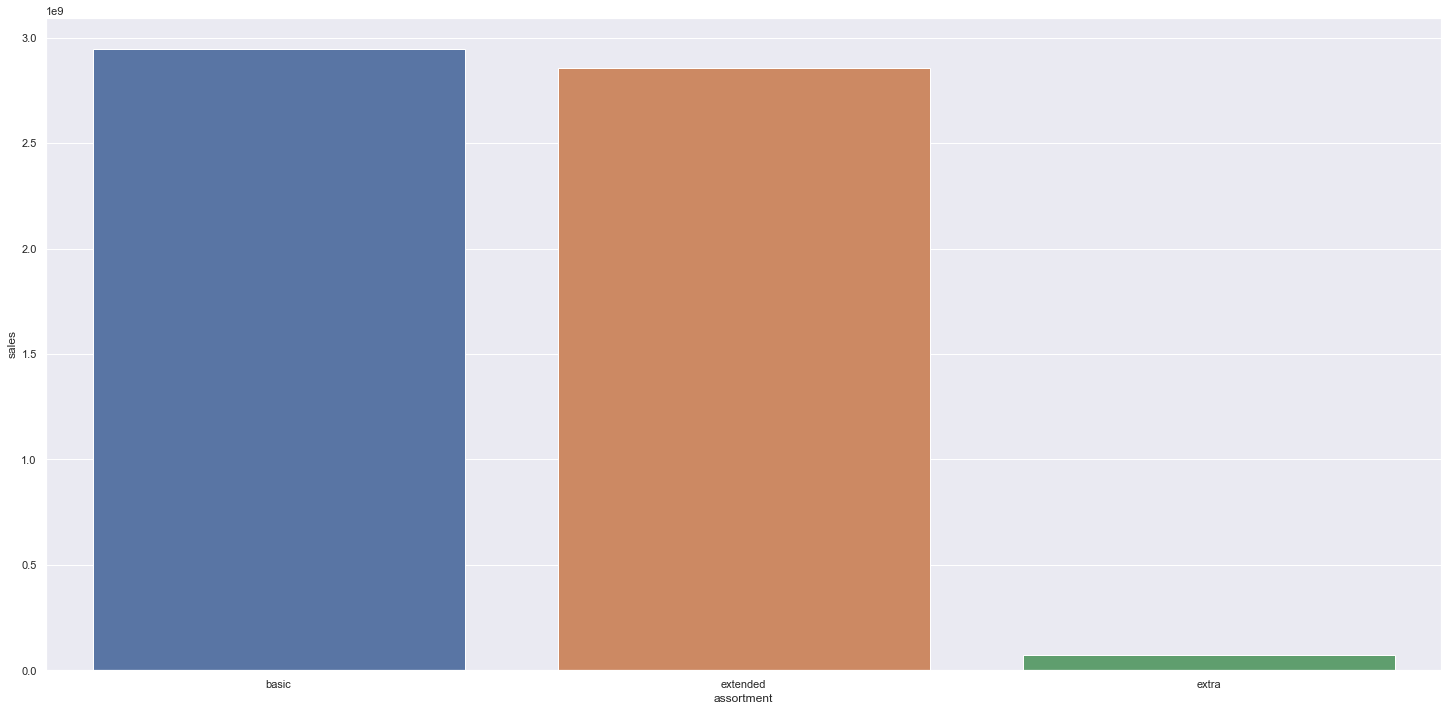

In [147]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
aux1
sns.barplot(x='assortment', y='sales',data=aux1);




<AxesSubplot:xlabel='year_week'>

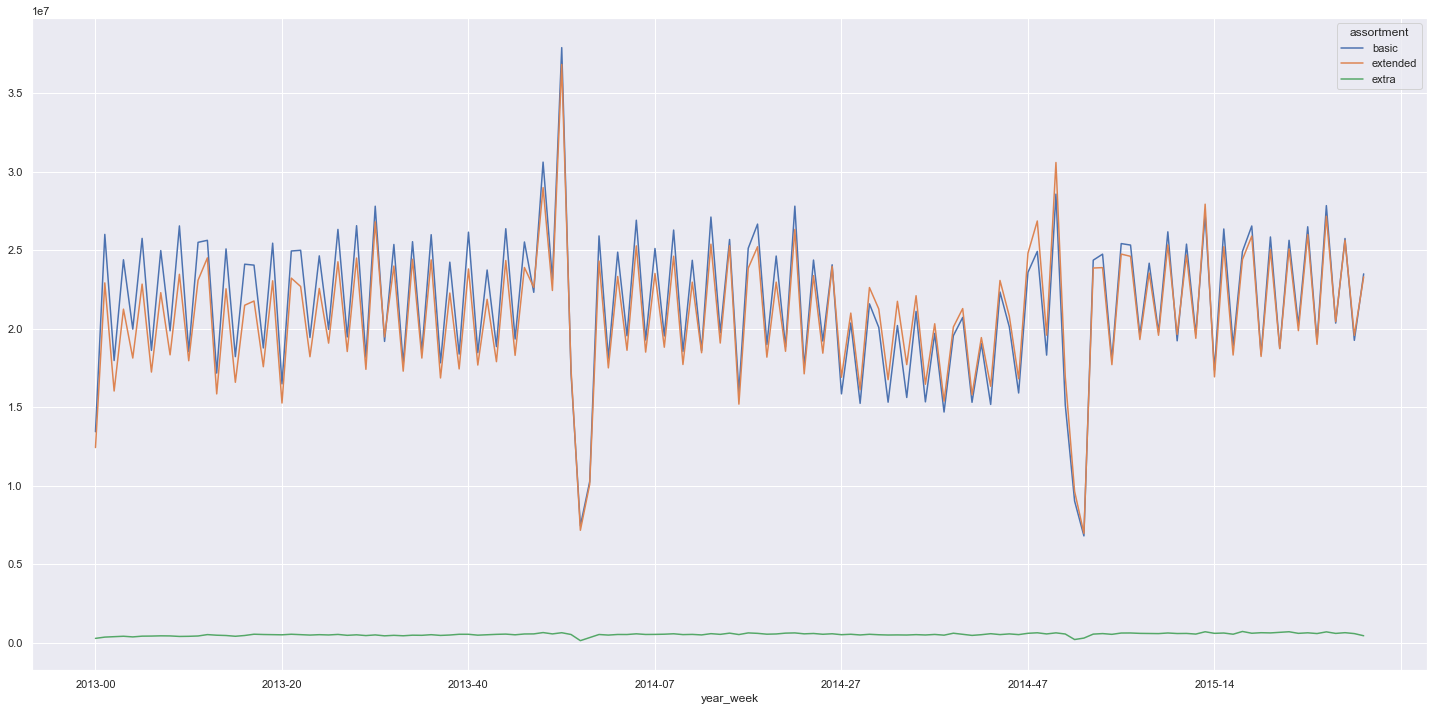

In [148]:
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


<AxesSubplot:xlabel='year_week'>

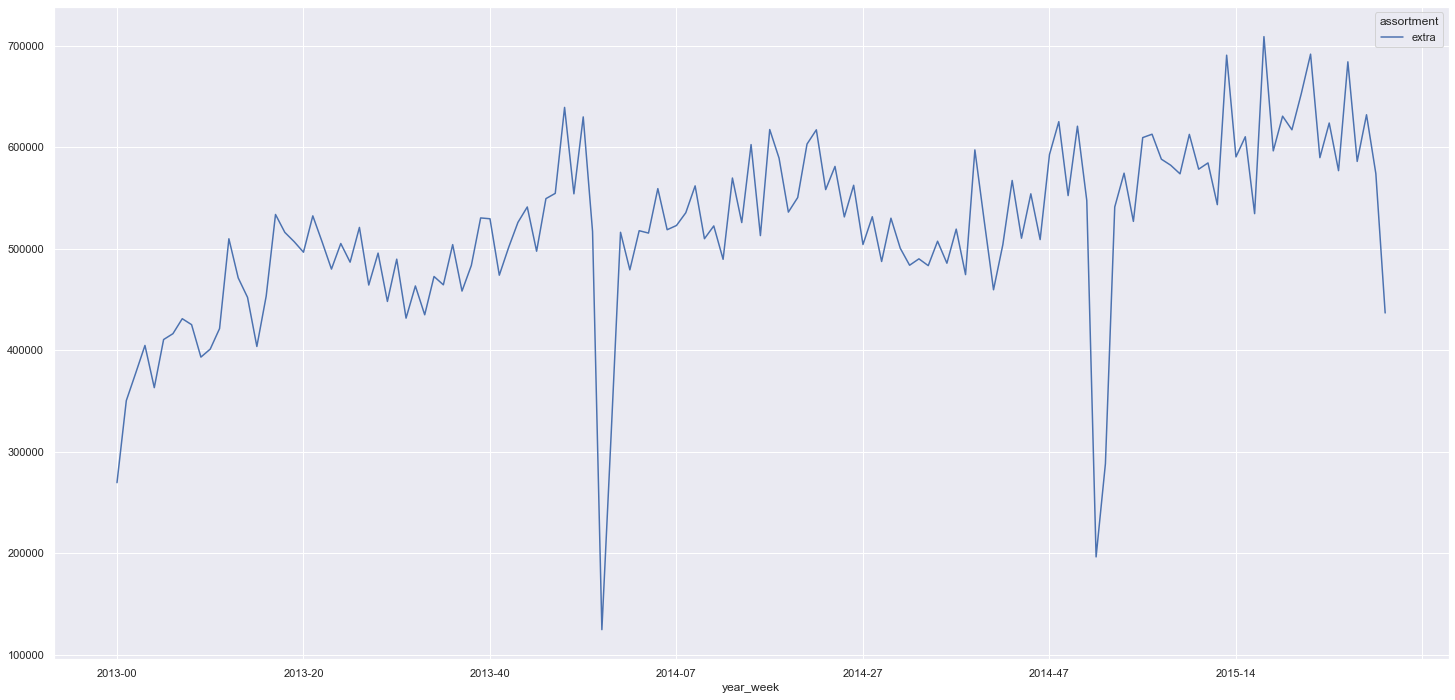

In [149]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com COMPETIDORES MAIS PERTO vendem MAIS.

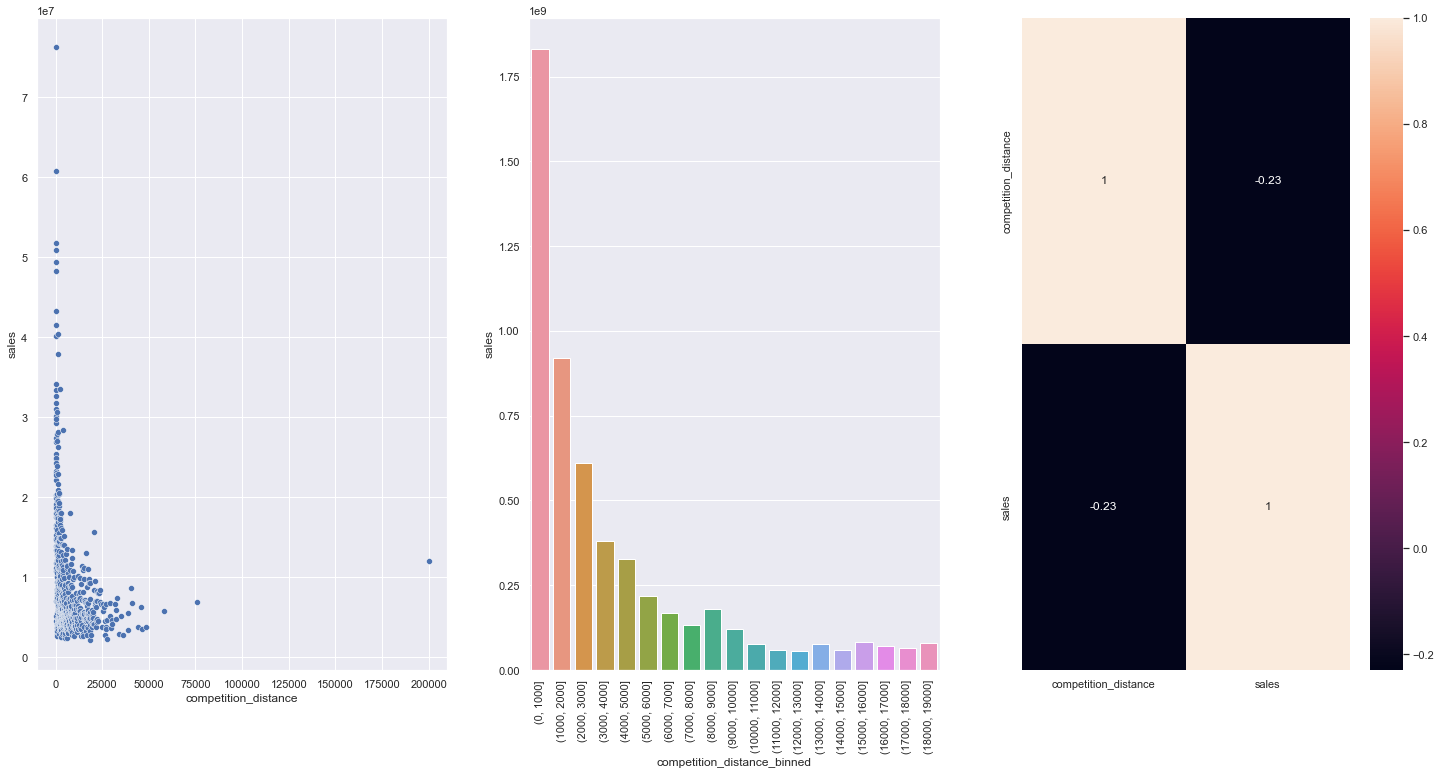

In [150]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index();
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90);


plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


#### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.

**FALSA** Lojas com competidores A MAIS TEMPO vendem MENOS.

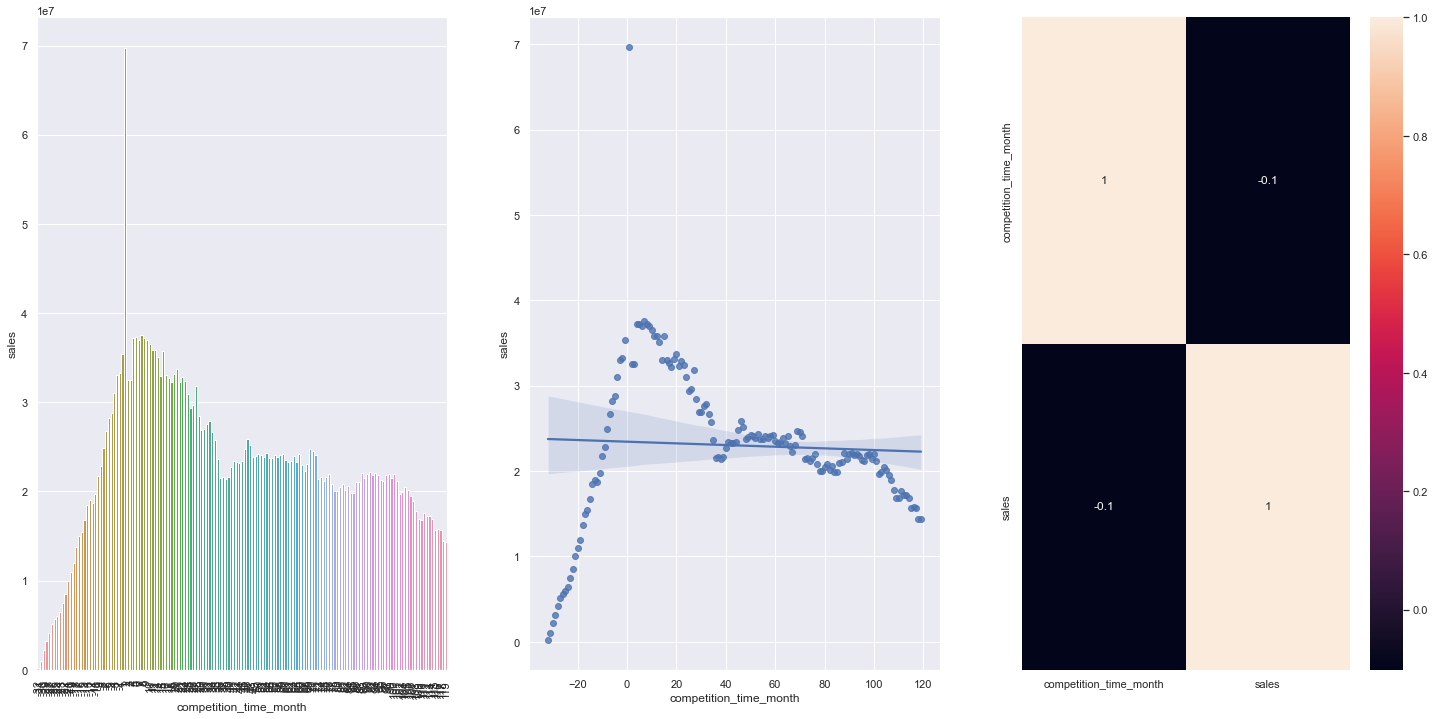

In [151]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month',y='sales',data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'),annot=True);

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao


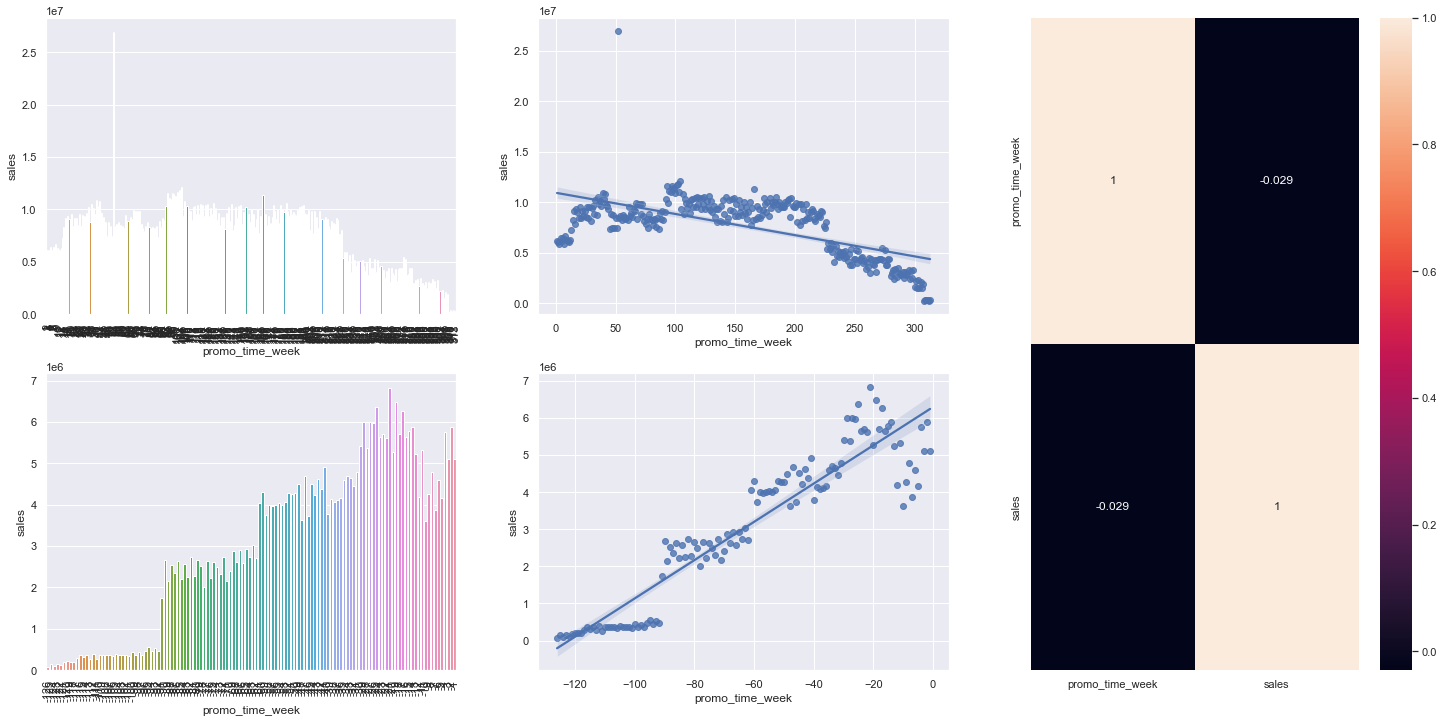

In [152]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


#### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

#### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [153]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


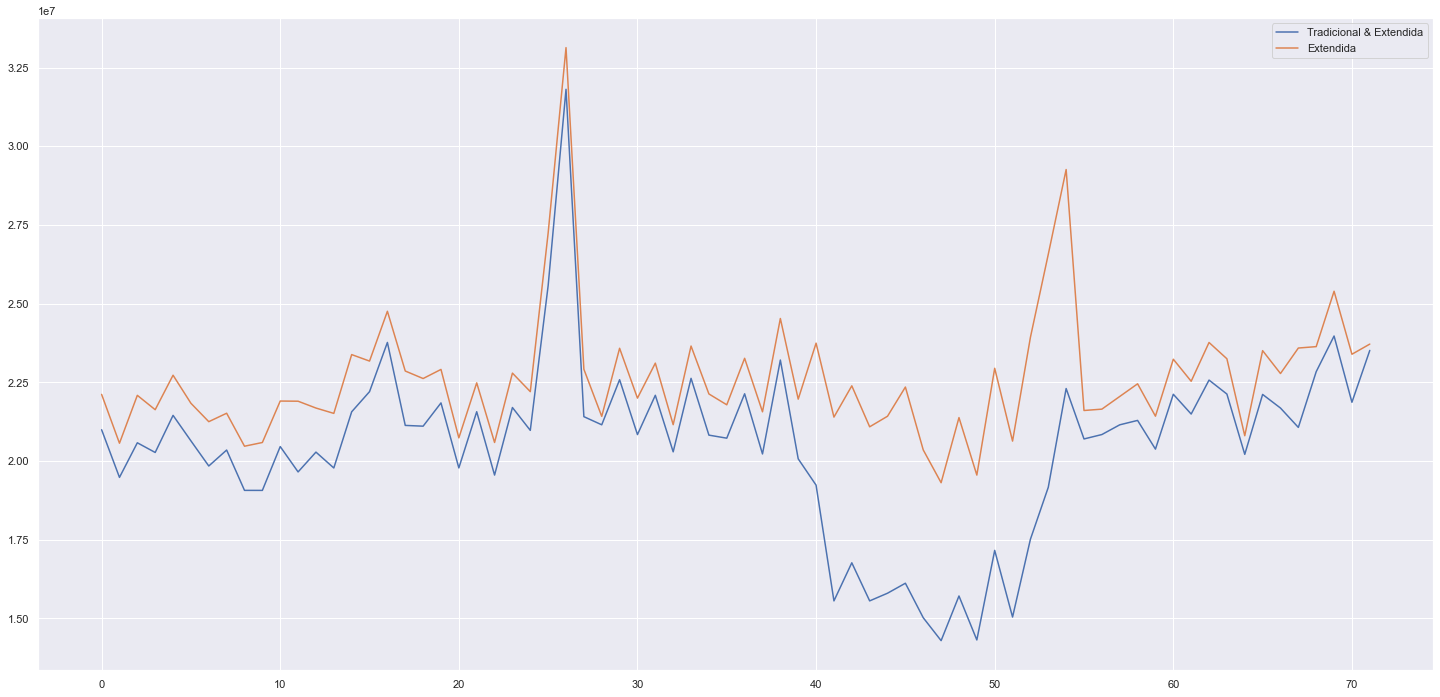

In [154]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

#### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

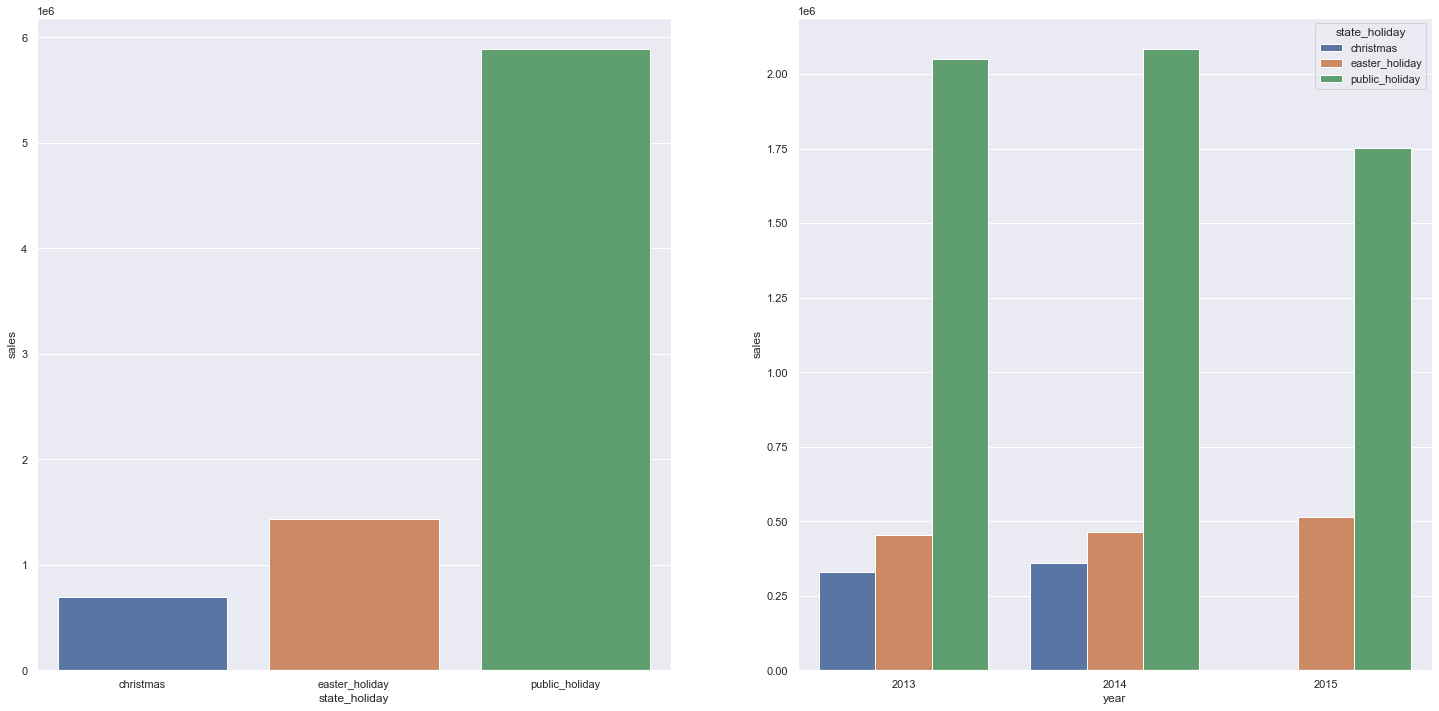

In [155]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

#### **H9.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

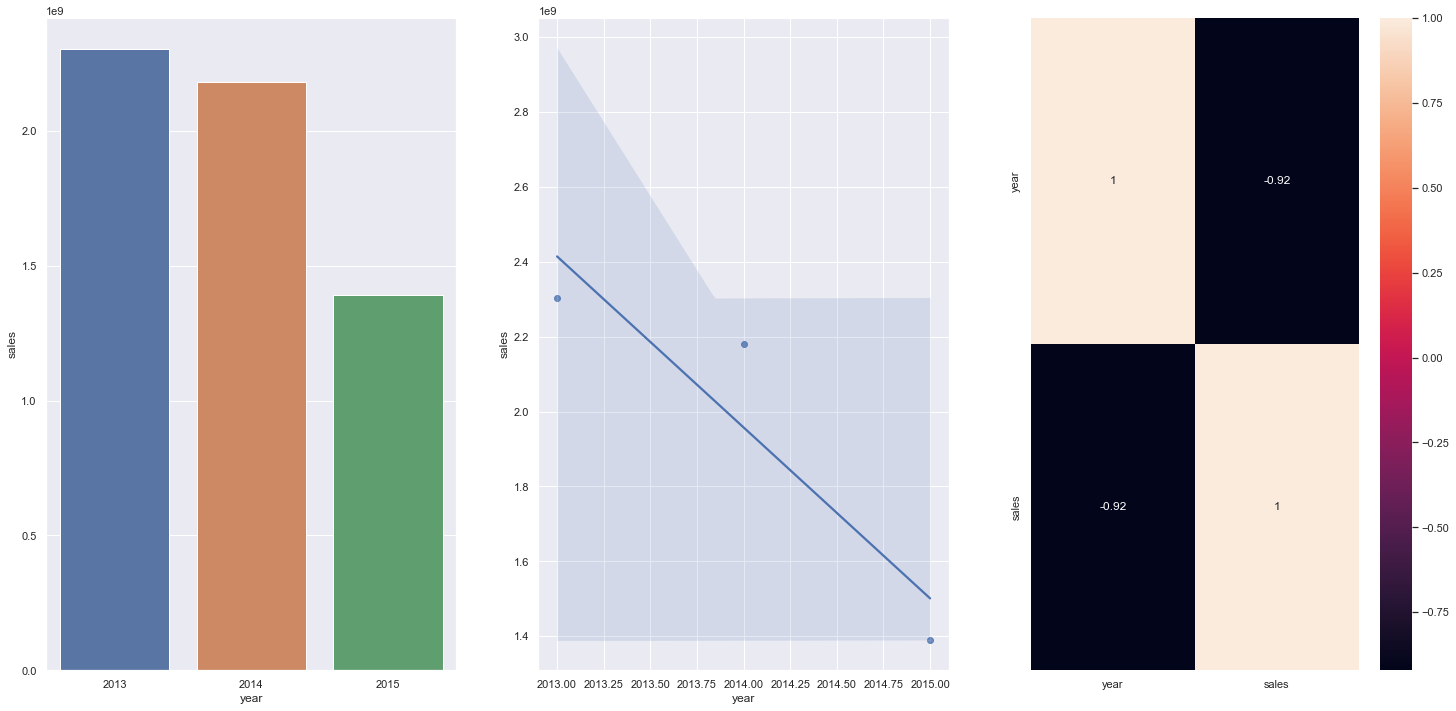

In [156]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

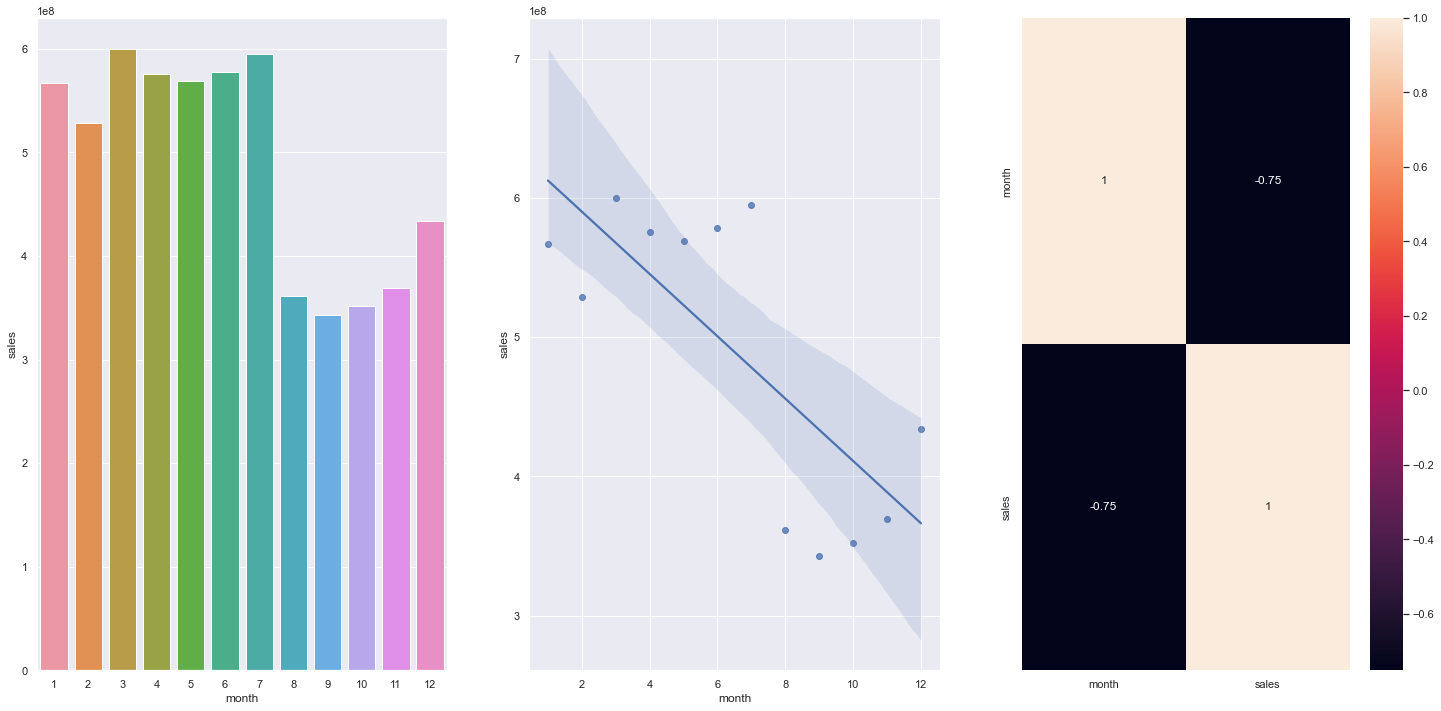

In [157]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

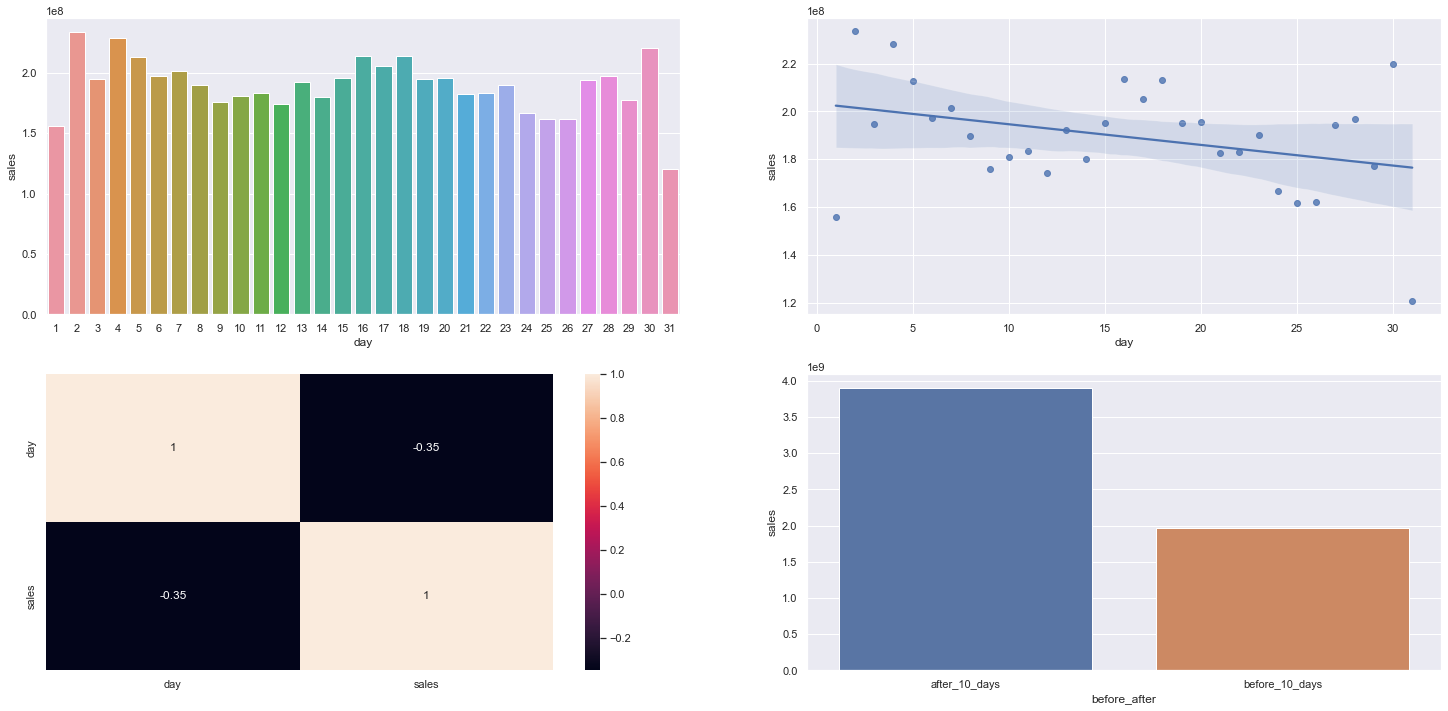

In [158]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

#### **H12.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

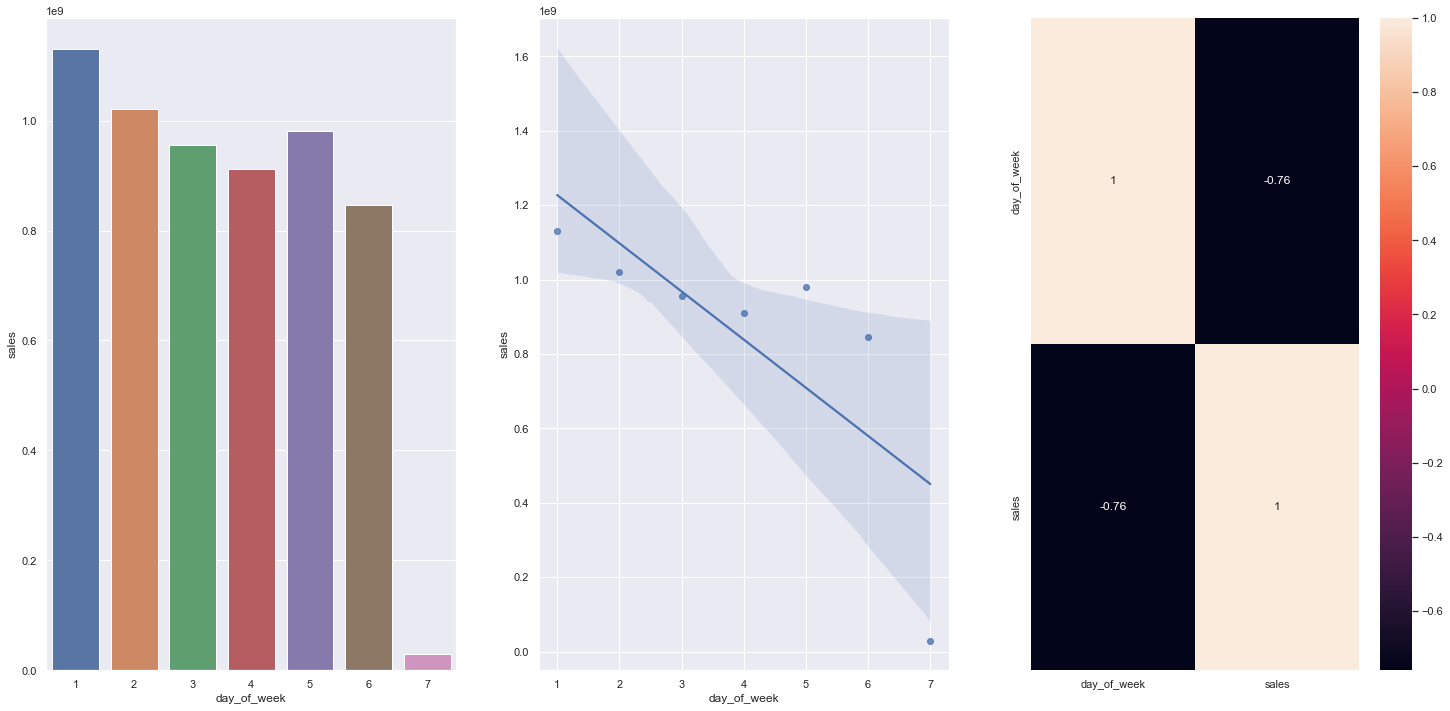

In [159]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

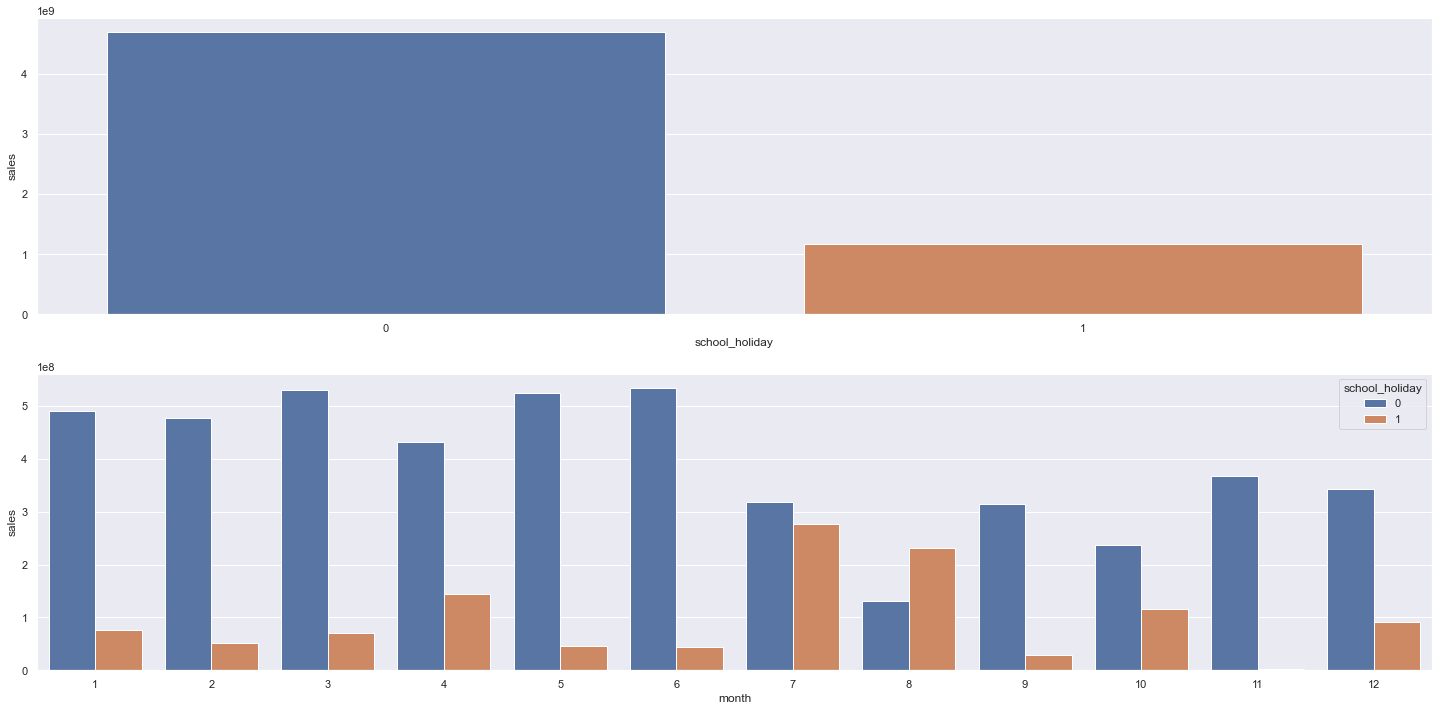

In [160]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1 Hypotesis Resume

In [161]:
from tabulate import tabulate

In [162]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


### 4.3 Multivariate Analysis

#### 4.3.1 Numerical Attributes

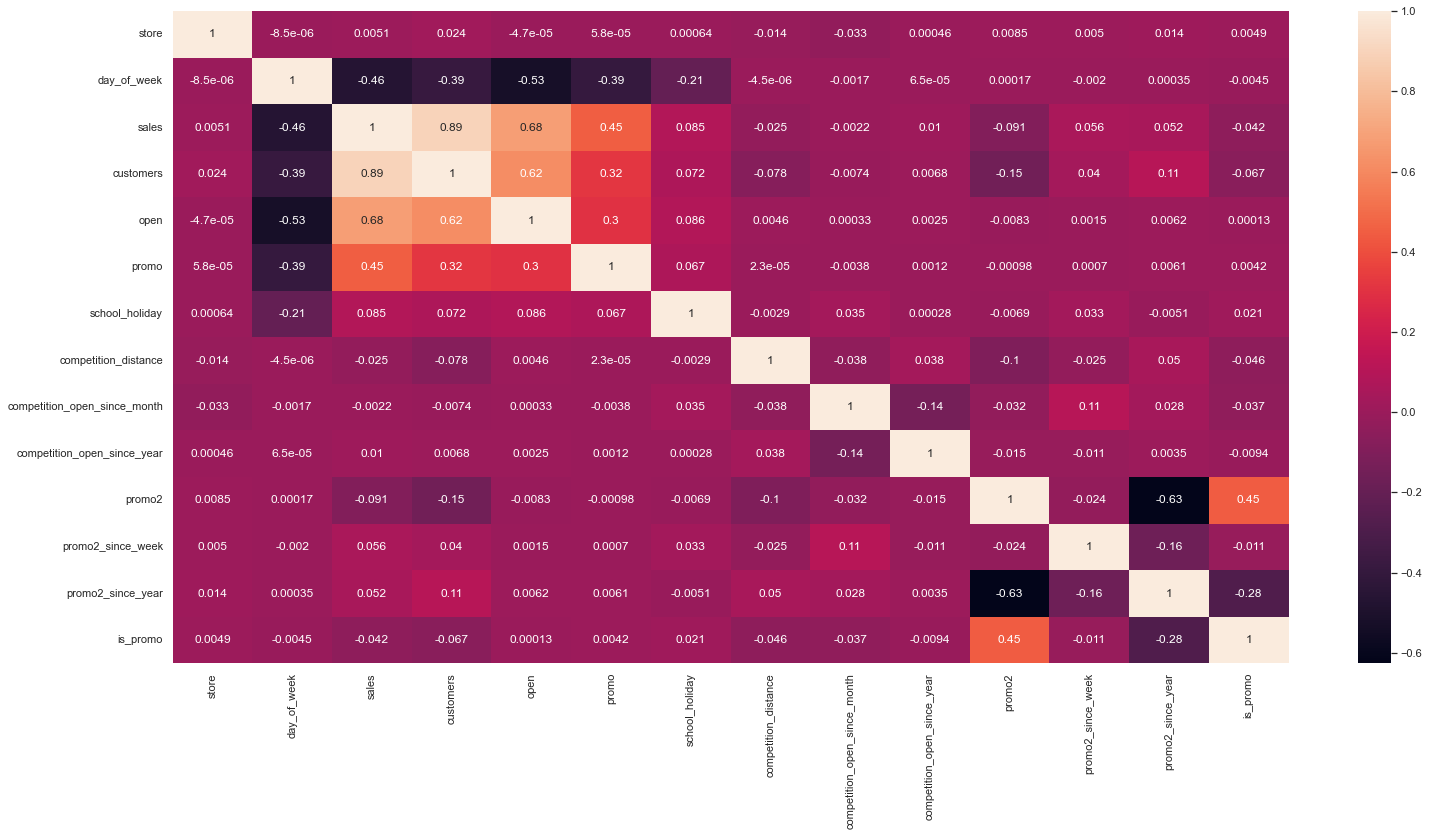

In [163]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

#### 4.3.2 Categorical Attributes

<AxesSubplot:>

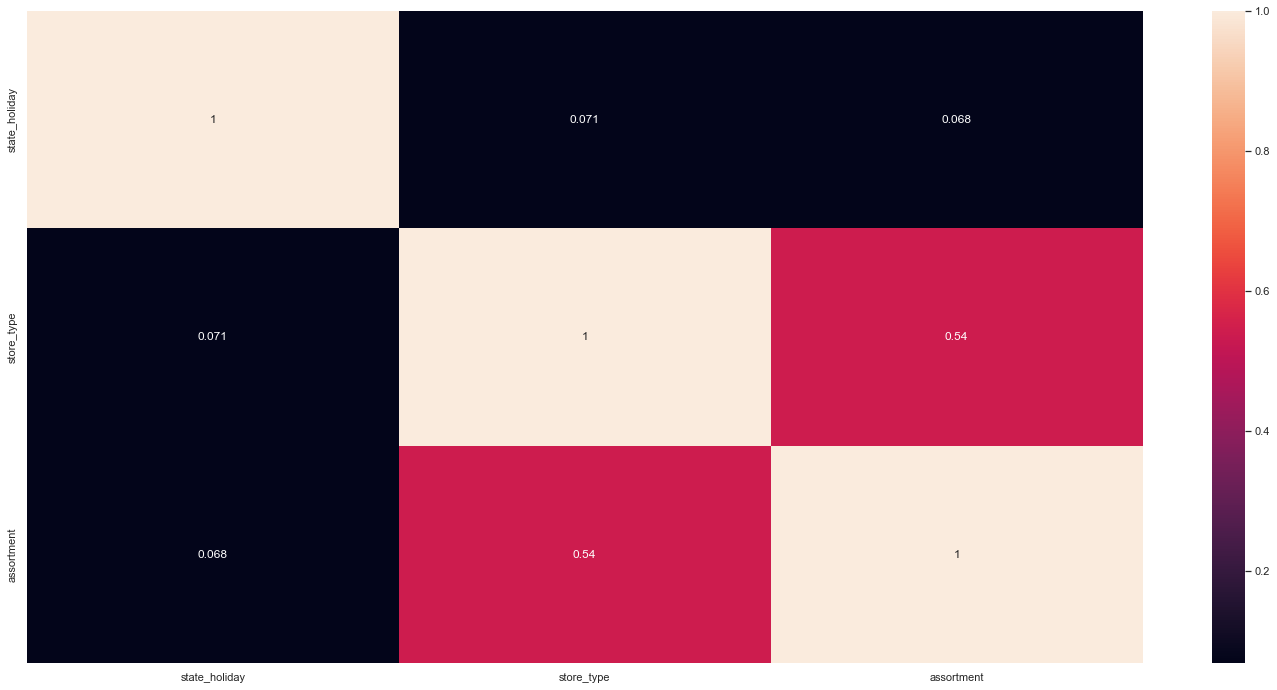

In [170]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })

d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0 Data Preparation

In [172]:
df5 = df4.copy()

## <s> 5.1 Normalization <s/>
    Nenhuma das variáveis tem distribuição normal, então decidi por não aplicar normalização em nenhuma delas.

## 5.2 Rescaling

## 5.3 Transformation